# Fast color mapping

In [ ]:
#| default_exp utils.colormap

In [ ]:
# |hide
# Stuff usef for dev/exploration purposes only.

from nbdev.showdoc import *
from fastcore.test import test_eq, is_close
from matplotlib import pyplot as plt
from lovely_tensors import monkey_patch

In [ ]:
# |hide
monkey_patch()

In [ ]:
# |export
from typing import Optional
from matplotlib import colormaps
from matplotlib.colors import to_rgba, ListedColormap
import torch
from torch.nn.functional import embedding

from lovely_tensors.repr_rgb import RGBProxy

In [ ]:
# |hide
in_stats = ( (0.485, 0.456, 0.406),(0.229, 0.224, 0.225) )

image = torch.load("mysteryman.pt")
image = (image * torch.tensor(in_stats[1])[:,None,None])
image += torch.tensor(in_stats[0])[:,None,None]

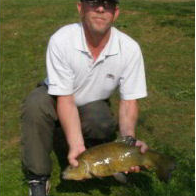

In [ ]:
image.rgb

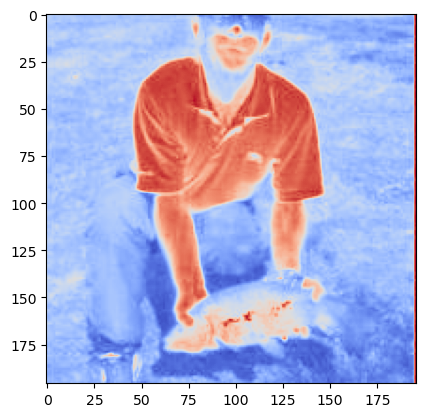

In [ ]:
# |hide
_ = plt.imshow(image[0], cmap="coolwarm") # One single channel.

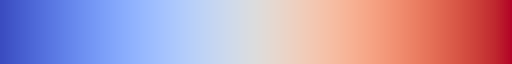

In [ ]:
# |hide
cmap = colormaps["coolwarm"]; cmap

In [ ]:
# |hide
cmap(0), cmap(0.5), cmap(1) # Maps float [0, 1] -> RGBA values. Works on np arrays.

((0.2298057, 0.298717966, 0.753683153, 1.0),
 (0.8674276350862745, 0.864376599772549, 0.8626024620196079, 1.0),
 (0.23437707945098038, 0.3055417303294118, 0.7596795275882353, 1.0))

In [ ]:
# |hide
# cmap has a lookup table with the structure:
#  0 ... 255 -> RGBA values for [0 , 1]
#        256 -> RGBA for below min
#        257 -> RGBA for above max
#        258 -> RGBA for NaN
cmap._lut.shape

(259, 4)

tensor[196, 196, 4] n=153664 x∈[0.016, 1.000] μ=0.796 σ=0.220


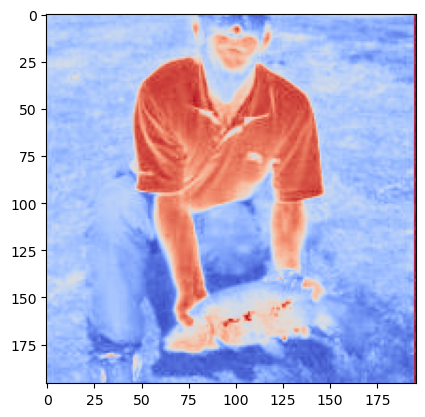

In [ ]:
# |hide
# Same, but use tensors
tensor_cmap = torch.from_numpy(cmap._lut).float()

# Converts values between 0..1 to integers betwen 0 and 255.
lut_idxs = image[0].mul(255).byte().long()

# Use F.embedding as a table lookup 
mapped = embedding(lut_idxs, tensor_cmap)

print(mapped)
_ = plt.imshow(mapped) # imshow is fine with channel-last RGBA.

In [ ]:
# |hide
# This works for tensors with arbitraty dimensions
# The RGBA is always slapped on as the last dimension.

image_batch = image.repeat(32,1,1,1)
print(image_batch)

lut_idxs = image_batch.mul(255).byte().long()
mapped = embedding(lut_idxs, tensor_cmap)

print(mapped)

tensor[32, 3, 196, 196] n=3687936 x∈[0., 1.000] μ=0.361 σ=0.248
tensor[32, 3, 196, 196, 4] n=14751744 x∈[0.016, 1.000] μ=0.775 σ=0.235


tensor[196, 196, 4] n=153664 x∈[0., 1.000] μ=0.775 σ=0.262


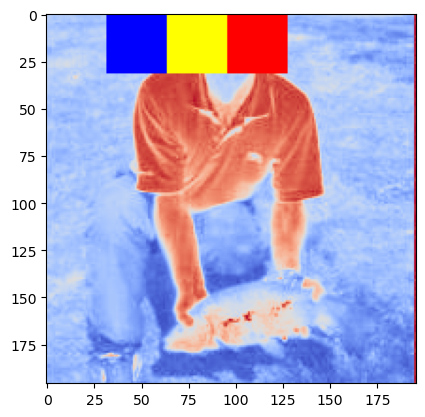

In [ ]:
# |hide
# Handle clipping and NaNs.
tensor_cmap = torch.from_numpy(cmap._lut).float()

bad_image = image.clone()

bad_image[0,0:32,32:64] = -0.1 # Below min
bad_image[0,0:32,64:96] = float("nan")
bad_image[0,0:32,96:128] = 1.1 # Above max

tensor_cmap[256] = torch.tensor([0., 0, 1, 1]) # Blue for below min
tensor_cmap[257] = torch.tensor([1., 0, 0, 1]) # Red for above max
tensor_cmap[258] = torch.tensor([1., 1, 0, 1]) # Yellow for NaNs

lut_idxs = bad_image.mul(255).byte().long()
lut_idxs[ bad_image < 0. ] = 256
lut_idxs[ bad_image > 1. ] = 257
lut_idxs[ bad_image.isnan()] = 258

# Use F.embedding as a table lookup mechanism
mapped = embedding(lut_idxs, tensor_cmap)

print(mapped[0])
_ = plt.imshow(mapped[0]) # imshow is fine with channel-last RGBA.

In [ ]:
# |hide
# Let's extend the lut to cover +/-inf too.

tensor_cmap_ninf = torch.tensor([[0, 1, 1, 1]]) # Cyan for -inf
tensor_cmap_pinf = torch.tensor([[1, 0, 1, 1]]) # Fuchsia for +inf

# Add mapping for -inf at positoin 259 and +inf at 260
tensor_cmap = torch.cat([
    tensor_cmap,
    tensor_cmap_ninf,
    tensor_cmap_pinf
], dim=0)

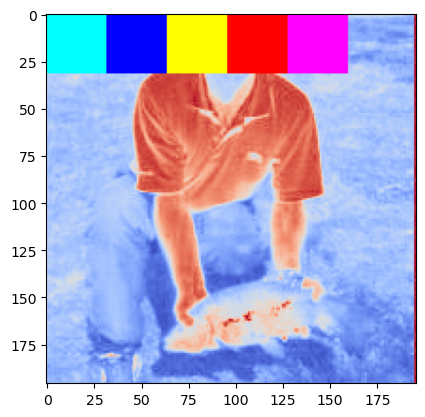

In [ ]:
# |hide
bad_image[0,0:32,0:32] = float("-inf")
bad_image[0,0:32,128:128+32] = float("+inf")

lut_idxs[ bad_image.isneginf() ] = 259
lut_idxs[ bad_image.isposinf() ] = 260

mapped = embedding(lut_idxs, tensor_cmap)
_ = plt.imshow(mapped[0]) # imshow is fine with channel-last RGBA.

In [ ]:
# |export
class TorchCmap():
    """
    Fast lut-based color mapping that is compatible with matplotlib colormaps

    Parameters extept `cmap` are matplotlib color strings.
    """
    def __init__(self,
                 cmap: ListedColormap, # Base matplotlib colormap
                 below: Optional[str] =None, # Values below 0
                 above: Optional[str] =None, # Values above 1
                 nan:   Optional[str] =None, # NaNs
                 ninf:  Optional[str] =None, # -inf
                 pinf:  Optional[str] =None, # +inf
                ):
        _ = cmap(0) # one call to make sure the cmap is initialized
        assert len(cmap._lut) == 259, "The colormap LUT should have 259 inputs"
        lut = torch.from_numpy(cmap._lut).float()
        
        if below: lut[256] = torch.tensor(to_rgba(below))
        if above: lut[257] = torch.tensor(to_rgba(above))
        if nan: lut[258] = torch.tensor(to_rgba(nan))

        # For +/- inf, use above/below as defaults.
        tensor_cmap_ninf = torch.tensor(to_rgba(ninf)) if ninf else lut[256]
        tensor_cmap_pinf = torch.tensor(to_rgba(pinf)) if pinf else lut[257]

        # Remove the alpha channel, it causes probems in pad_frame_gutters().
        self.lut = torch.cat([ lut, tensor_cmap_ninf[None], tensor_cmap_pinf[None] ])[:,:3]

    def __call__(self, t: torch.Tensor):
        lut_idxs = t.mul(255).byte().long()
        
        lut_idxs[ t < 0. ] = 256
        lut_idxs[ t > 1. ] = 257
        lut_idxs[ t.isnan()] = 258

        lut_idxs[ t.isneginf() ] = 259
        lut_idxs[ t.isposinf() ] = 260
        
        return embedding(lut_idxs, self.lut.to(t.device)) # RGB added as color-last.

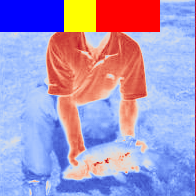

In [ ]:
tcmap = TorchCmap(colormaps["coolwarm"],
                  below="blue", above="red", nan="yellow")
tcmap(bad_image[0]).rgb(cl=True) # Note: Mapped only first channel

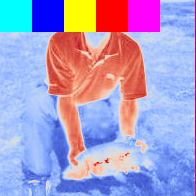

In [ ]:
tcmap = TorchCmap(colormaps["coolwarm"],
                  below="blue", above="red",
                  nan="yellow", ninf="cyan", pinf="fuchsia")
tcmap(bad_image)[0].rgb(cl=True) # Note: Mapped all channels, show only the mapping for the first.

In [ ]:
#Works with cuda, result stays on cuda.
if torch.cuda.is_available():
    img = tcmap(bad_image.to("cuda"))
    print(img)

tensor[3, 196, 196, 3] n=345744 x∈[0., 1.000] μ=0.682 σ=0.253 cuda:0


In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()